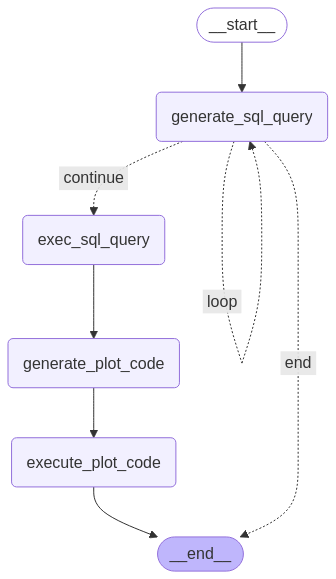

In [14]:
from typing import Literal
from typing_extensions import TypedDict
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
import generate_sql_query
import exec_sql_query
import generate_plot_code
import execute_plot_code

# Stateを宣言
class State(TypedDict):
    user_prompt: str
    sql_query: str
    generate_sql_query_count: int
    exec_results: any
    plot_code: str

# Nodeを宣言
def generate_sql_query_node(state: State, config: RunnableConfig):
    return {
        **state,
        "sql_query": generate_sql_query.generate_sql_query(state["user_prompt"]),
        "generate_sql_query_count": state["generate_sql_query_count"] + 1
    }

def check_sql_query(state: State, config: RunnableConfig) -> Literal["loop", "continue", "end"]:
    # 破壊的なSQLクエリでないかチェック
    upper_sql = state["sql_query"].upper()
    is_destructive = any(keyword in upper_sql for keyword in ["DROP", "DELETE", "TRUNCATE", "ALTER", "UPDATE", "RENAME", "INSERT", "CREATE"])
    if is_destructive:
        if state["generate_sql_query_count"] > 3:
            return "end"
        else:
            return "loop"
    else:
        return "continue"

def exec_sql_query_node(state: State, config: RunnableConfig):
    return {**state, "exec_results": exec_sql_query.execute_sql_query(state["sql_query"])}

def generate_plot_code_node(state: State, config: RunnableConfig):
    return {**state, "plot_code": generate_plot_code.generate_plot_code(state["exec_results"], state["user_prompt"])}

def execute_plot_code_node(state: State, config: RunnableConfig):
    return {**state, "image_base64": execute_plot_code.execute_plot_code(state["plot_code"])}

# Graphの作成
graph_builder = StateGraph(State)

# Nodeの追加
graph_builder.add_node("generate_sql_query", generate_sql_query_node)
graph_builder.add_node("exec_sql_query", exec_sql_query_node)
graph_builder.add_node("generate_plot_code", generate_plot_code_node)
graph_builder.add_node("execute_plot_code", execute_plot_code_node)

# Nodeをedgeに追加 
graph_builder.add_conditional_edges(
    "generate_sql_query",
    check_sql_query,
    {
        "loop": "generate_sql_query",
        "continue": "exec_sql_query",
        "end": END
    }
)
graph_builder.add_edge("exec_sql_query", "generate_plot_code")
graph_builder.add_edge("generate_plot_code", "execute_plot_code")

# Graphの始点を宣言
graph_builder.set_entry_point("generate_sql_query")

# Graphの終点を宣言
graph_builder.set_finish_point("execute_plot_code")

# Graphをコンパイル
graph = graph_builder.compile()

# Graphの表示
display(Image(graph.get_graph().draw_mermaid_png()))